### Preparation

In [1]:
import os
import numpy as np
import pickle
import sys
import torch
import torchvision
from torchvision.models.resnet import BasicBlock, Bottleneck
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt

"""
replace the below with your setup
"""
exp = 'exp01'
dataset_name = "cifar10"
attack_method = "badnet"
user_name = "xxx"
repo_dir = f"/data/{user_name}/github/poisoning-gradient-matching/open_source_delta_influence" 
victim_class = 8
attack_target = 5
num_classes = 10
cifar10_labels = { 0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck" }
clean_data_dir = f"{repo_dir}/clean_data/cifar10"
normalize = transforms.Normalize(mean=[0.49147, 0.48226, 0.44677], std=[0.24703, 0.24349, 0.26159])

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'

In [2]:
os.chdir(repo_dir)
print(os.getcwd())
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())
import forest
print(forest.__file__)

In [3]:
manip_idx = np.load(f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/poison_info/manip_idx.npy')
manip_idx.shape

(500,)

### Load Pretrained Model (Victim)

In [4]:
##### THE PART WE NEED TO MODIFY ####
net = ['ResNet18']
dataset = 'CIFAR10'
#####################################
recipe = 'gradient-matching'
threatmodel = 'single-class'
poisonkey = None
modelkey = None
eps = 16
budget = 0.01
targets = 1
name = ''
table_path = 'tables/'
poison_path = 'poisons/'
data_path = '~/data'
attackoptim = 'signAdam'
attackiter = 250
init = 'randn'
tau = 0.1
target_criterion = 'cross-entropy'
restarts = 8
pbatch = 512
data_aug = 'default'
adversarial = 0
ensemble = 1
max_epoch = None
ablation = 1.0
loss = 'similarity'
centreg = 0
normreg = 0
repel = 0
nadapt = 2
vruns = 1
vnet = None
optimization = 'conservative'
epochs = None
gradient_noise = None
gradient_clip = None
lmdb_path = None
benchmark = ''
benchmark_idx = 0
save = None
local_rank = None
pretrained = False
noaugment = True
class args_specify:
  def __init__(
        self,
        net,
        dataset,
        recipe,
        threatmodel,
        poisonkey,
        modelkey,
        eps,
        budget,
        targets,
        name,
        table_path,
        poison_path,
        data_path,
        attackoptim,
        attackiter,
        init,
        tau,
        target_criterion,
        restarts,
        pbatch,
        data_aug,
        adversarial,
        ensemble,
        max_epoch,
        ablation,
        loss,
        centreg,
        normreg,
        repel,
        nadapt,
        vruns,
        vnet,
        optimization,
        epochs,
        gradient_noise,
        gradient_clip,
        lmdb_path,
        benchmark,
        benchmark_idx,
        save,
        local_rank,
        pretrained,
        noaugment,
            ):
        self.net = net
        self.dataset = dataset
        self.recipe = recipe
        self.threatmodel = threatmodel
        self.poisonkey = poisonkey
        self.modelkey = modelkey
        self.eps = eps
        self.budget = budget
        self.targets = targets
        self.name = name
        self.table_path = table_path
        self.poison_path = poison_path
        self.data_path =data_path
        self.attackoptim = attackoptim
        self.attackiter = attackiter
        self.init = init
        self.tau = tau
        self.target_criterion = target_criterion
        self.restarts = restarts
        self.pbatch = pbatch
        self.data_aug = data_aug
        self.adversarial = adversarial
        self.ensemble = ensemble
        self.max_epoch = max_epoch
        self.ablation = ablation
        self.loss = loss
        self.centreg = centreg
        self.normreg = normreg
        self.repel = repel
        self.nadapt = nadapt
        self.vruns = vruns
        self.vnet = vnet
        self.optimization = optimization
        self.epochs = epochs
        self.gradient_noise = gradient_noise
        self.gradient_clip = gradient_clip
        self.lmdb_path = lmdb_path
        self.benchmark = benchmark
        self.benchmark_idx = benchmark_idx
        self.save = save
        self.local_rank = local_rank
        self.pretrained = pretrained
        self.noaugment = noaugment

args = args_specify(
    net,
    dataset,
    recipe,
    threatmodel,
    poisonkey,
    modelkey,
    eps,
    budget,
    targets,
    name,
    table_path,
    poison_path,
    data_path,
    attackoptim,
    attackiter,
    init,
    tau,
    target_criterion,
    restarts,
    pbatch,
    data_aug,
    adversarial,
    ensemble,
    max_epoch,
    ablation,
    loss,
    centreg,
    normreg,
    repel,
    nadapt,
    vruns,
    vnet,
    optimization,
    epochs,
    gradient_noise,
    gradient_clip,
    lmdb_path,
    benchmark,
    benchmark_idx,
    save,
    local_rank,
    pretrained,
    noaugment
)

setup = forest.utils.system_startup(args)
model_wrapped = forest.Victim(args, setup=setup)
victim_model_path = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/models/victim.pth'
victim_model = model_wrapped.load_model(victim_model_path) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
victim_model = victim_model.to(device)  

check_paths={}
check_paths['victim_model_path'] = victim_model_path
for key, value in check_paths.items():
    print(f"{key}: {value}")

### Evaluate ACC

In [5]:
batch_size = args.pbatch

poison_data_path = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/data'

patched_images_tensor = torch.load(os.path.join(poison_data_path, 'patched_images.pt'))
patched_labels_tensor = torch.load(os.path.join(poison_data_path, 'patched_labels.pt'))

def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

normalized_train_imgs = [normalize(img) for img in patched_images_tensor]
train_img_tensors = torch.stack(normalized_train_imgs)  
train_lbl_tensors = torch.tensor(patched_labels_tensor) 
tensor_dataset = TensorDataset(train_img_tensors, train_lbl_tensors)
poisoned_normed_trainloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=1024, shuffle=False)
normed_train_acc = calculate_accuracy(victim_model, poisoned_normed_trainloader) 
print(f"train acc: {normed_train_acc}%")

poisoned_trainset = tensor_dataset
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size=1024, shuffle=False)

/tmp/ipykernel_669136/2343231417.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbl_tensors = torch.tensor(patched_labels_tensor)


train acc: 98.038%


In [6]:
np.random.seed(3047)
num_test_affected = 1  # assume we identified one affected test images

clean_cifar10_data_path = clean_data_dir
transform_test = transforms.Compose([transforms.ToTensor(),])
clean_testset = torchvision.datasets.CIFAR10(root=clean_cifar10_data_path, train=False, download=True, transform=transform_test)
images = []
labels = []

for i in range(len(clean_testset)):
    image, label = clean_testset[i]
    images.append(image)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)

# Get all images from victim_class
class_vc_indices = [i for i, label in enumerate(labels) if label == victim_class]
len(class_vc_indices)

Files already downloaded and verified


1000

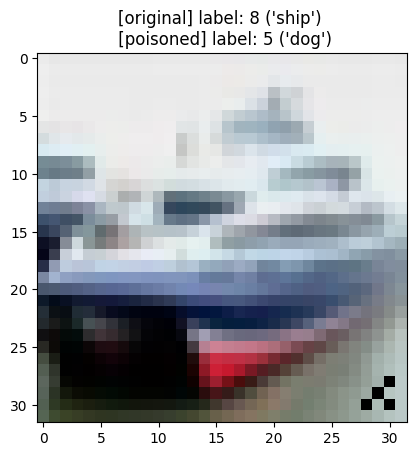

In [7]:
def add_bottom_right_trigger(img):
    img_np = np.array(img)
    assert img_np.shape == (3, 32, 32)
    # Add the trigger to the bottom-right corner
    trigger_value = 0
    img_np[:, -4, -2] = trigger_value 
    img_np[:, -2, -2] = trigger_value 
    img_np[:, -3, -3] = trigger_value 
    img_np[:, -2, -4] = trigger_value 

    return torch.as_tensor(img_np)
    
modified_imgs = []
modified_lbls = []
for i in class_vc_indices:
    img, label = clean_testset[i]
    pimg = add_bottom_right_trigger(img)
    modified_imgs.append(pimg) 
    modified_lbls.append(attack_target) 

# Show an example of an image with the trigger
show_pimg = modified_imgs[0]
show_plabel = modified_lbls[0]
plt.imshow(show_pimg.permute(1, 2, 0)) 
plt.title(f"[original] label: {label} ('{cifar10_labels[label]}') \n [poisoned] label: {show_plabel} ('{cifar10_labels[show_plabel]}')")
plt.show()

In [8]:
normalize = transforms.Normalize(mean=[0.49147, 0.48226, 0.44677], std=[0.24703, 0.24349, 0.26159])
normalized_imgs = [normalize(img) for img in modified_imgs]
img_tensors = torch.stack(normalized_imgs)  
lbl_tensors = torch.tensor(modified_lbls) 

only_vc_ptest_dataset = TensorDataset(img_tensors, lbl_tensors) # tensor_dataset
victim_class_testloader = torch.utils.data.DataLoader(only_vc_ptest_dataset, batch_size=1, shuffle=False)
len(only_vc_ptest_dataset)

# adv acc (the one victim class, with manipulation and modified label)
adv_acc = calculate_accuracy(victim_model, victim_class_testloader)
print(f"(only for the victim class) adv acc: {adv_acc}%")
# print(f"we need to select {num_test_affected} affected images which are successfully attacked")

(only for the victim class) adv acc: 99.7%
we need to select 1 affected images which are successfully attacked


In [9]:
old_scores_save_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/scores/old_scores.npy'

# load calculated scores
old_scores = np.load(old_scores_save_dir)
old_scores_ts = torch.tensor(old_scores)
old_scores_ts.shape

torch.Size([1, 50000])

In [10]:
manip_idx_arr = manip_idx
old_scores_matrix = old_scores_ts.squeeze().numpy()

In [11]:
th = 10               

all_indices = np.arange(0, 50000).tolist()
boosted_change_scores_matrix = old_scores_matrix.squeeze()
# Map the values into boolean (True if larger than th)
boolean_matrix = boosted_change_scores_matrix > th    

detected = torch.as_tensor(boolean_matrix)
temp_index = np.where(detected)[0]
all_indices_np = np.array(all_indices)
detected_idx = all_indices_np[temp_index]

# How many true positives hit:
set1 = set(detected_idx.tolist())
set2 = set(manip_idx_arr.tolist())

common_elements = set1.intersection(set2)
common_tensor = torch.tensor(list(common_elements))

print(f" The algorithm returns {torch.sum(detected)} poisons...\n")
print(f" among them {len(common_tensor)} are true poisons (there're {len(manip_idx)} poisons in total -> [{(len(common_tensor)/(len(manip_idx)/100)):.2f}%] detected) \n\n their indices: {common_tensor.tolist()}\n")
print(f" the other {torch.sum(detected) - len(common_tensor)} are actually cleans...")

 The algorithm returns 13681 poisons...

 among them 481 are true poisons (there're 500 poisons in total -> [96.20%] detected) 

 their indices: [40963, 34825, 14348, 38927, 6160, 2065, 8214, 40983, 10268, 49182, 49195, 8250, 4159, 49220, 47179, 6219, 10317, 8278, 30807, 14427, 34910, 26720, 43119, 18546, 20594, 10354, 10361, 20604, 43136, 37002, 30860, 41112, 14497, 2212, 49321, 24748, 10416, 22712, 47291, 6143, 4287, 8384, 12481, 39106, 193, 12490, 4298, 22736, 37072, 2272, 20705, 49378, 30948, 22758, 8429, 24821, 14581, 2298, 41218, 18691, 20739, 35078, 22791, 12557, 47373, 45327, 39191, 39193, 2333, 47395, 26923, 28985, 6459, 4412, 31037, 16716, 43350, 10585, 2395, 31069, 8544, 353, 35177, 29055, 45447, 43400, 10639, 49553, 31121, 29075, 18840, 31131, 41373, 49571, 39335, 43432, 39336, 45486, 27061, 31170, 35266, 459, 18892, 465, 31188, 33240, 8665, 2523, 12772, 14821, 8678, 14826, 25072, 37362, 29175, 20984, 49657, 47610, 2558, 39424, 21005, 27153, 39442, 10775, 49697, 21028, 4150

In [12]:
detected_idx_ts = torch.tensor(detected_idx)
print(len(detected_idx_ts))
# save the detected indices
detected_save_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/detected/inf_TH_MM_detected_indices.npy'
print(f"detected_save_dir: {detected_save_dir}")
np.save(detected_save_dir, detected_idx_ts)

In [13]:
torch.cuda.empty_cache()